In [1]:
import os
import torch
import torchvision
import mlflow
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn as NN
import torch.optim as optim

In [2]:
# Detecting if a GPU is available:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used: {torch.cuda.get_device_name(0)}") if device == "cuda" else print("No GPU available: Using CPU")

Device used: NVIDIA GeForce RTX 5080


### Defining the GAN architecture

In [3]:
class Generator(NN.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = NN.Sequential(
            NN.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            NN.BatchNorm2d(ngf * 8),
            NN.ReLU(True),
            NN.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ngf * 4),
            NN.ReLU(True),
            NN.ConvTranspose2d(ngf * 4, ngf *2, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ngf * 2),
            NN.ReLU(True),
            NN.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ngf),
            NN.ReLU(True),
            NN.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            NN.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(NN.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = NN.Sequential(
            NN.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            NN.LeakyReLU(0.2, inplace=True),
            NN.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ndf * 2),
            NN.LeakyReLU(0.2, inplace=True),
            NN.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ndf * 4),
            NN.LeakyReLU(0.2, inplace=True),
            NN.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ndf * 8),
            NN.LeakyReLU(0.2, inplace=True),
            NN.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            NN.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [4]:
# Weights init function:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        NN.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        NN.init.normal_(m.weight.data, 1.0, 0.02)
        NN.init.constant_(m.bias.data, 0)

In [5]:
# Train function for discriminator:
def train_epoch(dataloader, netG, netD, criterion, nz, optimizerG, optimizerD, device, real_label_smoth):

    # Metric acumulators:
    running_g_loss = 0.0
    running_d_loss = 0.0
    running_d_x = 0.0
    running_d_g_z1 = 0.0
    running_d_g_z2 = 0.0

    for _, data in enumerate(dataloader, 0):
        ########################## Update the DISCRIMINATOR ##########################
        netD.zero_grad()

        real_images = data[0].to(device)
        b_size = real_images.size(0)

        label = torch.full((b_size,), real_label_smoth, dtype=torch.float, device=device)

        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake images:
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)

        label.fill_(0.)

        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ########################## Update the GENERATOR ##########################
        netG.zero_grad()

        label.fill_(1.)

        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        running_g_loss += errG.item()
        running_d_loss += errD.item()
        running_d_x += D_x
        running_d_g_z1 += D_G_z1
        running_d_g_z2 += D_G_z2

    n_batches = len(dataloader) # Length of the current batch

    # Getting metric means:
    avg_g_loss = running_g_loss / n_batches
    avg_d_loss = running_d_loss / n_batches
    avg_d_x = running_d_x / n_batches
    avg_d_g_z1 = running_d_g_z1 / n_batches
    avg_d_g_z2 = running_d_g_z2 / n_batches

    return avg_g_loss, avg_d_loss, avg_d_x, avg_d_g_z1, avg_d_g_z2

In [6]:
# Ploting function:
def plot_epoch(epoch, netG, fixed_noise, plots_filename):
    # Generate images:
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()

    # Show images:
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    # Tomamos 64 imagenes y hacemos un grid
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake, padding=2, normalize=True).numpy(), (1,2,0)))
    
    plt.savefig(plots_filename, bbox_inches='tight') 
    plt.show()
    plt.close() # Close to save RAM

In [7]:
# MLFLow information:
EXPERIMENT_NAME = "GAN_capsules_v1"
RUN_NAME = "Try: Set a learning rate for every net"
SAVE_MODEL_TO_MLFLOW = True

if SAVE_MODEL_TO_MLFLOW:
    RUN_NAME = RUN_NAME
else:
    RUN_NAME = f"{RUN_NAME} - NO model saved"

# Hyperparameters:
HP_LR_G = 2e-4 # Learning rate for generator
HP_LR_D = 5e-5 # Learning rate for discriminator
HP_NZ = 100 # Size of noise input vector (latent space)
HP_NC = 3 # Number of channels of the input image (RGB)
HP_NGF = 64 # Number of feature maps in the generator
HP_NDF = 64 # Number of feature maps in the discriminator
HP_N_EPOCHS = 25 # Total training epochs
HP_BATCH_SIZE = 128 # Number of inputs (images) per batch
HP_MODEL_ARCH = "DCGAN" # Model architecture tested
HP_LOSS_FCN = "BCELoss" # Loss Function
HP_OPTIMIZER = "Adam" # Optimizer
HP_REAL_LABEL_SMOOTH = 0.9 # Target for real images

In [8]:
# Transforming the data:
transform = T.Compose([
    T.Resize(64),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize([0.5] * 3, [0.5] * 3)
])

# Create the dataloader from dataset:
dataset = torchvision.datasets.ImageFolder(
    root="../data/raw/capsule/train", 
    transform=transform
    )
if device == "cuda":
    train_dataloader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=HP_BATCH_SIZE, 
        shuffle=True,
        num_workers=4, # CPU threads loading the batches
        pin_memory=True, # Transfer form RAM to VRAM
        persistent_workers=True # Same CPU threads in every epoch
        )
    print("Optimizing batches using GPU")
else:
    train_dataloader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=HP_BATCH_SIZE, 
        shuffle=True,
        )

Optimizing batches using GPU


In [9]:
# Create the generator and discriminator:
netG = Generator(HP_NZ, HP_NGF, HP_NC).to(device)
netD = Discriminator(HP_NC, HP_NDF).to(device)

# Init the weights:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
# Define the loss function:
criterion = NN.BCELoss()

# Define the optimizers
optimizerG = optim.Adam(netG.parameters(), lr=HP_LR_G, betas=(0.5, 0.9999))
optimizerD = optim.Adam(netD.parameters(), lr=HP_LR_D, betas=(0.5, 0.9999))

Init training...
Logging parameters to MLFlow
Starting MLFlow Run: Try: Set a learning rate for every net
 Epochs: [0 / 25] Loss_G: 0.4625 Loss_D: 3.4495 D(x): 0.6851 D(G(z)): 0.8363 / 0.6886


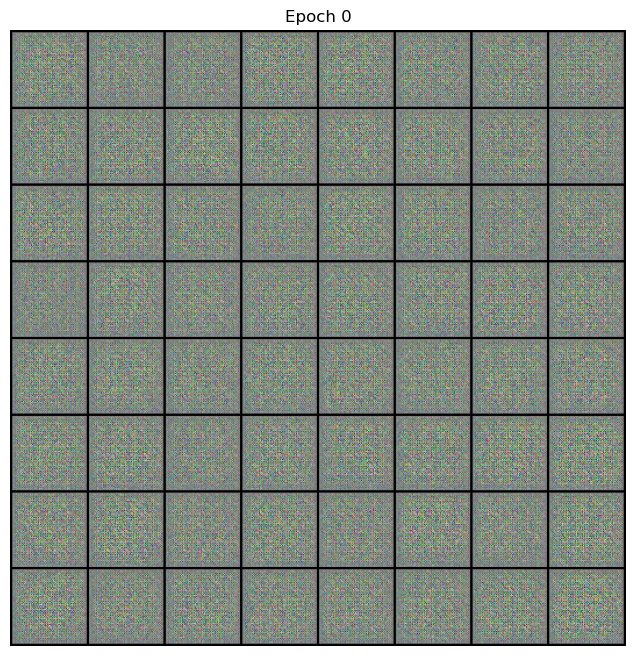

 Epochs: [1 / 25] Loss_G: 0.1397 Loss_D: 5.2379 D(x): 0.9974 D(G(z)): 0.9819 / 0.8798
 Epochs: [2 / 25] Loss_G: 0.1985 Loss_D: 4.8326 D(x): 0.9601 D(G(z)): 0.9810 / 0.8329
 Epochs: [3 / 25] Loss_G: 0.2006 Loss_D: 5.0202 D(x): 0.8069 D(G(z)): 0.9857 / 0.8282
 Epochs: [4 / 25] Loss_G: 0.2689 Loss_D: 5.0569 D(x): 0.8924 D(G(z)): 0.9865 / 0.7795
 Epochs: [5 / 25] Loss_G: 0.3458 Loss_D: 5.1270 D(x): 0.8571 D(G(z)): 0.9887 / 0.7238


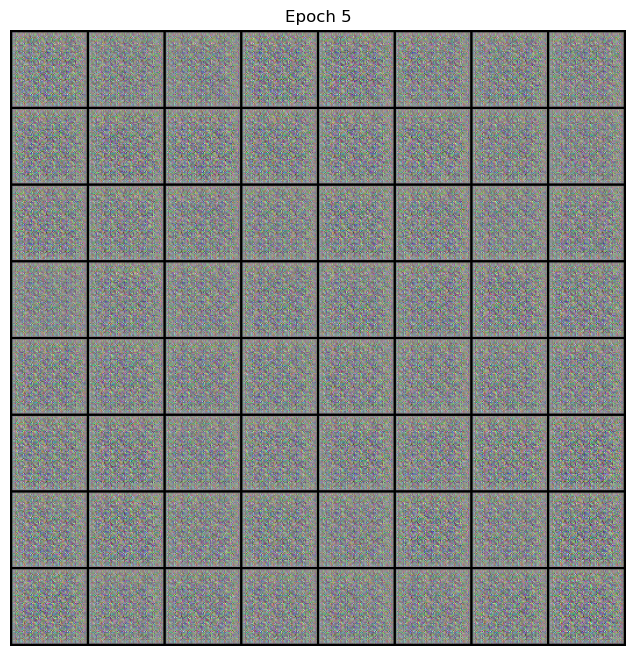

 Epochs: [6 / 25] Loss_G: 0.3889 Loss_D: 5.4054 D(x): 0.8513 D(G(z)): 0.9902 / 0.6989
 Epochs: [7 / 25] Loss_G: 0.4344 Loss_D: 5.8209 D(x): 0.8472 D(G(z)): 0.9944 / 0.6693
 Epochs: [8 / 25] Loss_G: 0.6345 Loss_D: 5.7419 D(x): 0.8462 D(G(z)): 0.9937 / 0.5607
 Epochs: [9 / 25] Loss_G: 0.7940 Loss_D: 5.8223 D(x): 0.8421 D(G(z)): 0.9942 / 0.4908
 Epochs: [10 / 25] Loss_G: 1.0555 Loss_D: 5.6214 D(x): 0.8416 D(G(z)): 0.9934 / 0.3779


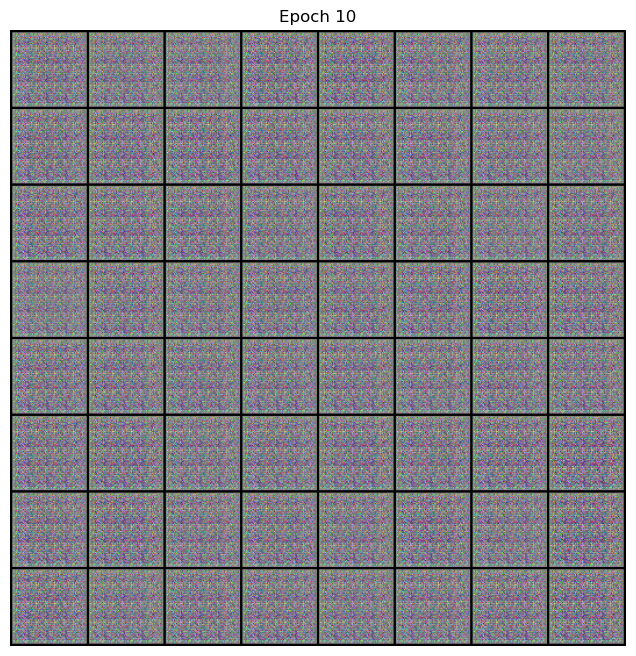

 Epochs: [11 / 25] Loss_G: 1.7030 Loss_D: 5.0365 D(x): 0.8490 D(G(z)): 0.9881 / 0.2106
 Epochs: [12 / 25] Loss_G: 2.0731 Loss_D: 4.8197 D(x): 0.8629 D(G(z)): 0.9859 / 0.1470
 Epochs: [13 / 25] Loss_G: 2.6470 Loss_D: 4.4262 D(x): 0.8632 D(G(z)): 0.9784 / 0.0861
 Epochs: [14 / 25] Loss_G: 3.4439 Loss_D: 3.5443 D(x): 0.8680 D(G(z)): 0.9488 / 0.0403
 Epochs: [15 / 25] Loss_G: 3.9382 Loss_D: 2.8740 D(x): 0.8733 D(G(z)): 0.9034 / 0.0246


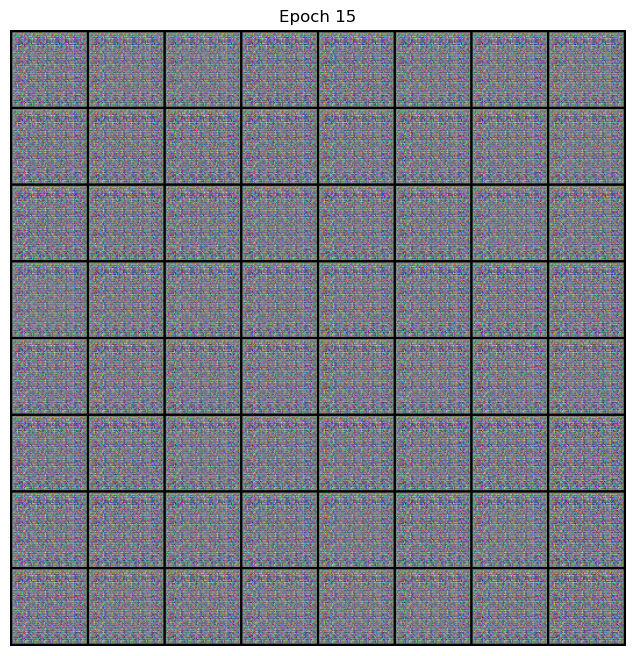

 Epochs: [16 / 25] Loss_G: 4.3006 Loss_D: 2.5757 D(x): 0.8593 D(G(z)): 0.8794 / 0.0160
 Epochs: [17 / 25] Loss_G: 4.5656 Loss_D: 2.3593 D(x): 0.8692 D(G(z)): 0.8466 / 0.0128
 Epochs: [18 / 25] Loss_G: 4.4726 Loss_D: 2.4614 D(x): 0.8648 D(G(z)): 0.8589 / 0.0140
 Epochs: [19 / 25] Loss_G: 4.6654 Loss_D: 2.2024 D(x): 0.8624 D(G(z)): 0.8210 / 0.0117
 Epochs: [20 / 25] Loss_G: 5.1013 Loss_D: 1.6537 D(x): 0.8639 D(G(z)): 0.7013 / 0.0076


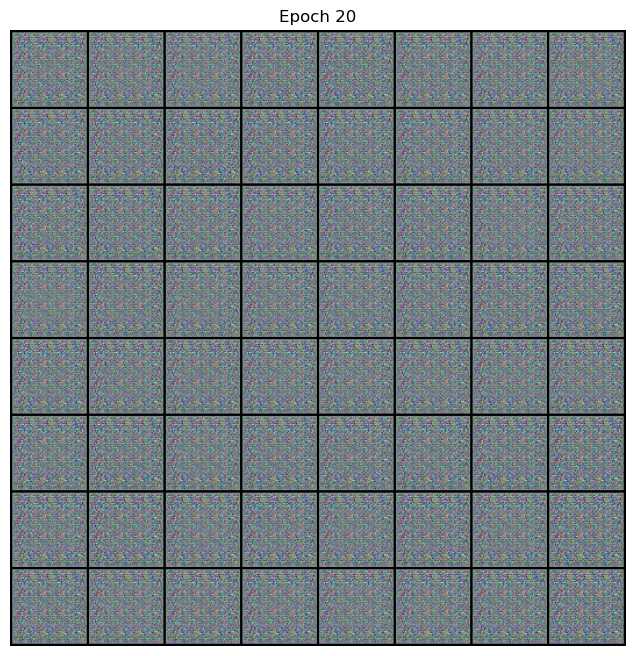

 Epochs: [21 / 25] Loss_G: 5.0280 Loss_D: 1.4164 D(x): 0.8758 D(G(z)): 0.6413 / 0.0076
 Epochs: [22 / 25] Loss_G: 4.8814 Loss_D: 1.5817 D(x): 0.8691 D(G(z)): 0.6880 / 0.0091
 Epochs: [23 / 25] Loss_G: 4.9721 Loss_D: 1.6059 D(x): 0.8714 D(G(z)): 0.6968 / 0.0082


2025/11/17 20:36:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/17 20:36:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


 Epochs: [24 / 25] Loss_G: 5.0079 Loss_D: 1.3704 D(x): 0.8640 D(G(z)): 0.6227 / 0.0077
Training completed. Saving model...


2025/11/17 20:36:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/17 20:36:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved; training completed.


In [11]:
# ==========================================================================
# ####### MODEL TRAINING (EXCECUTE ONLY IF RE-TRAINING IS NECESSARY) #######
# ==========================================================================

MLFLOW_TRACKING = True

if MLFLOW_TRACKING:

    mlflow.set_experiment(EXPERIMENT_NAME)

    with mlflow.start_run(run_name=RUN_NAME):
        print("Init training...")
        print("Logging parameters to MLFlow")
        mlflow.log_param('learning_rate_generator', HP_LR_G)
        mlflow.log_param('learning_rate_discriminator', HP_LR_D)
        mlflow.log_param('latent_space_size', HP_NZ)
        mlflow.log_param('channels_input_image', HP_NC)
        mlflow.log_param('n_feature_maps_generator', HP_NGF)
        mlflow.log_param('n_feature_maps_discriminator', HP_NDF)
        mlflow.log_param('n_epochs', HP_N_EPOCHS)
        mlflow.log_param('batch_size', HP_BATCH_SIZE)
        mlflow.log_param('model_architecture', HP_MODEL_ARCH)
        mlflow.log_param('loss_function', HP_LOSS_FCN)
        mlflow.log_param('optimizer', HP_OPTIMIZER)
        mlflow.log_param('real_label_smoth', HP_REAL_LABEL_SMOOTH)

        print(f"Starting MLFlow Run: {mlflow.active_run().info.run_name}")


        # Define fixed noise to produce consistent outputs during training:
        fixed_noise = torch.randn(64, HP_NZ, 1, 1, device=device) # Gausian noise

        # Loss histories:
        loss_g_history = []
        loss_d_history = []

        for epoch in range(HP_N_EPOCHS):
            avg_g_loss, avg_d_loss, avg_d_x, avg_d_g_z1, avg_d_g_z2 = train_epoch(
                dataloader=train_dataloader,
                netG=netG,
                netD=netD,
                criterion=criterion,
                nz=HP_NZ,
                optimizerG=optimizerG,
                optimizerD=optimizerD,
                device=device,
                real_label_smoth=HP_REAL_LABEL_SMOOTH
            )

            loss_g_history.append(avg_g_loss)
            loss_d_history.append(avg_d_loss)

            print(  f" Epochs: [{epoch} / {HP_N_EPOCHS}] "
                    f"Loss_G: {avg_g_loss:.4f} "
                    f"Loss_D: {avg_d_loss:.4f} "
                    f"D(x): {avg_d_x:.4f} "
                    f"D(G(z)): {avg_d_g_z1:.4f} / {avg_d_g_z2:.4f}"
                )
            
            mlflow.log_metric('avg_g_loss', avg_g_loss, step=epoch)
            mlflow.log_metric('avg_d_loss', avg_d_loss,step=epoch)
            mlflow.log_metric('avg_d_x', avg_d_x, step=epoch)
            mlflow.log_metric('avg_d_g_z1', avg_d_g_z1, step=epoch)
            mlflow.log_metric('avg_d_g_z2', avg_d_g_z2, step=epoch)
            
            if epoch % 5 == 0:

                # Save figure temporaly:
                plots_save_dir = f"../reports/figures/{HP_MODEL_ARCH}"
                os.makedirs(plots_save_dir, exist_ok=True)

                plots_filename=f"{plots_save_dir}/epoch_{epoch}.png"

                plot_epoch(
                    epoch=epoch,
                    netG=netG,
                    fixed_noise=fixed_noise,
                    plots_filename=plots_filename
                )

                # Save to MLFlow:
                mlflow.log_artifact(plots_filename, 'plots')
                os.remove(plots_filename) # Remove to avoid duplicates.

        # Saving the trained model:
        print("Training completed. Saving model...")
        model_g_save_dir = f"../models/{HP_MODEL_ARCH}_g_capsules.pth" # Save dir of generator
        torch.save(netG.state_dict(), model_g_save_dir)
        if SAVE_MODEL_TO_MLFLOW:
            mlflow.log_artifact(model_g_save_dir, 'model_generator')
            mlflow.pytorch.log_model(netG, artifact_path="model_generator")
        print("Model saved; training completed.")
